In [12]:
import torch.optim as optim
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import argparse
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.models as torchvision_models
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

from attnloss import AttnLoss
from contrastloss import ContrastLoss
from LSWEncoderOnly import EncoderOnly
from LSWNet import LSWNet
import random

In [13]:
class EncoderOnly(nn.Module):
    def __init__(self, hidden_size, kernel_size=3):
        super(EncoderOnly, self).__init__()
        
        # 使用原始编码器部分的结构
        self.conv_encoder1 = nn.Sequential(
            nn.BatchNorm1d(1),
            nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.t_encoder1 = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=4, batch_first=True),
            num_layers=1
        )

        self.conv_encoder2 = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.t_encoder2 = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=4, batch_first=True),
            num_layers=1
        )

        self.conv_encoder3 = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.t_encoder3 = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=4, batch_first=True),
            num_layers=1
        )
        
        self.T_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=4, batch_first=True),
            num_layers=3
        )
    
    def forward(self, x):
        # 编码器部分的前向传播与原始模型相同
        B, T, N, _ = x.size()
        
        x = x.view(B * T, 1, N)
        x1 = self.conv_encoder1(x)
        x1 = x1.transpose(1, 2)
        x1 = self.t_encoder1(x1)
        x1 = x1.transpose(1, 2)
        
        x2 = self.conv_encoder2(x1)
        x2 = x2.transpose(1, 2)
        x2 = self.t_encoder2(x2)
        x2 = x2.transpose(1, 2)
        
        x3 = self.conv_encoder3(x2)
        x3 = x3.transpose(1, 2)
        x3 = self.t_encoder3(x3)
        x3 = x3.transpose(1, 2)
        
        x = x3.view(B, T, -1, x3.size(-1))
        x = x.permute(0, 2, 1, 3).contiguous().view(B * N // 8, T, -1)
        x_encoder = self.T_encoder(x)
        
        return x_encoder



In [14]:
class LSWNet(nn.Module):
    def __init__(self, hidden_size, kernel_size=3):
        super(LSWNet, self).__init__()
        
        # Pool first
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        # Encoder Layers
        self.conv_encoder1 = nn.Sequential(
            nn.BatchNorm1d(1),
            nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        self.conv1= nn.Sequential(
            nn.ConvTranspose1d(hidden_size, hidden_size, kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.conv2= nn.Sequential(
            nn.ConvTranspose1d(hidden_size, hidden_size, kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.ConvTranspose1d(hidden_size, 1, kernel_size=2, stride=2),
            nn.LeakyReLU()
        )
        self.sigmoid = nn.Sigmoid()

    
    def forward(self, x):

        # Input (B, T, N, C)
        B, T, N, _ = x.size()
        x = x.permute(0, 2, 3, 1).contiguous()  # 将形状从 (B, T, N, 1) 改为 (B, N, 1, T)
        x = x.view(B * N, -1, T)  # 将形状从 (B, N, 1, T) 改为 (B * N, 1, T)
        # x = alpha_0 * self.avg_pool(output) + alpha_1 * self.max_pool(output)
        x = self.avg_pool(x).view(B, N, -1).permute(0, 2, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x格式是(B,1,8N)
        x = self.sigmoid(x)
        x = x.transpose(1, 2)
       
        return x

In [15]:
class PointCloudSequenceDataset(Dataset):
    def __init__(self, data, T):
        self.data = data
        self.T = T
        self.padding = T // 2

    def __len__(self):
        # 总长度为可以提取的序列数
        return len(self.data) - 2 * self.padding

    def __getitem__(self, idx):
        # 计算索引范围，中心帧前后各 padding 帧
        start = idx
        end = idx + self.T
        # 从原始数据中提取形状为 (T, N) 的子序列
        sequence = self.data[start:end]
        return torch.tensor(sequence, dtype=torch.float32)

In [65]:
import matplotlib.pyplot as plt
import numpy as np

def get_image(points):
    x, y = [], []
    for k in range(len(points)):
        theta = k / 900 * np.pi
        px = - points[k] * np.cos(theta)
        py = points[k] * np.sin(theta)
        x.append(px)
        y.append(py)
    return x, y

# def get_color(attn):
#     c = []
#     for a in attn:
#         if a < 0.2:
#             c.append("#fff143")
#         elif a < 0.5:
#             c.append("#ffb61e")
#         elif a < 0.75:
#             c.append("#ff7500")
#         else:
#             c.append("r")
#     return c

def get_color(attn):
    c = []
    for a in attn:
        if a < 0.1:
            c.append("#ffff00")  # 黄色
        elif a < 0.3:
            c.append("#ffcc00")  # 深橙色
        elif a < 0.5:
            c.append("#ff9900")  # 橙色
        elif a < 0.7:
            c.append("#ff6600")  # 浅橙色
        elif a < 0.9:
            c.append("#ff3300")  # 深红色
        else:
            c.append("#ff0000")  # 红色
    return c

# def get_shape(attn):
#     s = []
#     for a in attn:
#         if a < 0.2:
#             s.append(0.3)
#         elif a < 0.5:
#             s.append(0.8)
#         elif a < 0.75:
#             s.append(1.5)
#         else:
#             s.append(2)
#     return s

def get_shape(attn):
    s = []
    for a in attn:
        if a < 0.1:
            s.append(0.8*2)  # 非常小
        elif a < 0.3:
            s.append(1.6*2)  # 较小
        elif a < 0.5:
            s.append(2.4*2)  # 小
        elif a < 0.7:
            s.append(3.2*2)  # 中等
        elif a < 0.9:
            s.append(4.0*2)  # 大
        else:
            s.append(4.8*2)  # 非常大
    return s

In [16]:
# 加载数据
data_path = "/media/cyj/DATA/Self_Feature_LO/dianxin6.npy"
point_cloud_data = np.load(data_path) 

(1800,)


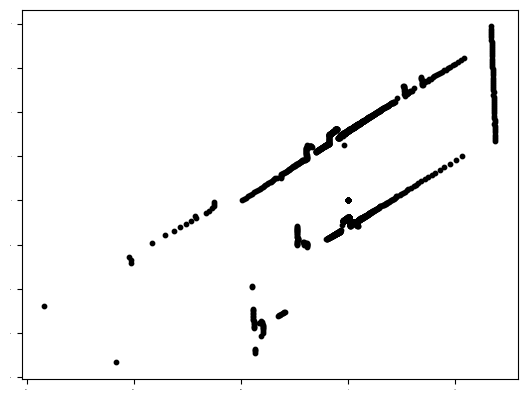

In [75]:
data_test = point_cloud_data[500,:]
print(data_test.shape)
data_test[data_test>100]=0
x, y = get_image(data_test)
plt.scatter(x, y, c="black",s=10)  # 绘制点，颜色为黑色
#     plt.title("Raw Data", fontsize=50)  # 设置标题
#     plt.xlabel('', fontsize=40)
#     plt.ylabel('', fontsize=40)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontsize(0)

plt.show()  # 显示图形

# 第二幅图
plt.figure(figsize=(16, 16))  # 为第二幅图创建新的图形对象
c = get_color(weights)  # 根据注意力权重获取颜色值
plt.scatter(x, y, c=c,s=120)  # 绘制点，颜色根据注意力权重确定
#     plt.title("Weighted Data", fontsize=50)  # 设置标题
#     plt.xlabel('', fontsize=40)
#     plt.ylabel('', fontsize=40)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontsize(0)

plt.show()  # 显示图形


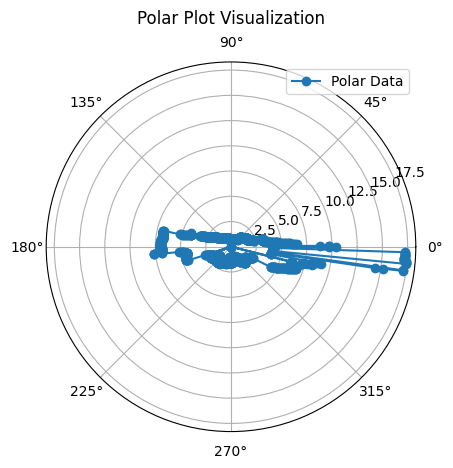

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# 示例数据：半径 r
r = point_cloud_data[10000,:]
r[r > 100] = 0

np.savetxt('r_values.txt', r, fmt='%.6f')

# 生成角度 theta，假设均匀分布
theta = np.linspace(0, 2 * np.pi, len(r), endpoint=False)

# 创建极坐标图
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, r, marker='o', linestyle='-', label='Polar Data')

# 添加图例和标题
ax.legend()
ax.set_title('Polar Plot Visualization', va='bottom')

# 显示图形
plt.show()


In [17]:
n, N = point_cloud_data.shape

# 定义 T 的长度
T = 5
assert T % 2 == 1, "T 必须是奇数，以便能对称地选择前后帧"
padding = T // 2  # 对称 padding，用于从每帧提取前后相邻帧
valid_frames = n - 2 * padding  # 可用帧数量

hidden_size = 128
kernel_size = 7

# 创建 Dataset 实例
dataset = PointCloudSequenceDataset(point_cloud_data, T=T)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 实例化并加载保存的编码器权重
encoder_only_model = EncoderOnly(hidden_size=hidden_size, kernel_size=kernel_size)
encoder_params_path = "/media/cyj/DATA/Self_Feature_LO/src/point_cloud_processing/model/LSencoder/encoder_params002.pth"
encoder_state_dict = torch.load(encoder_params_path, map_location=device)

# 加载参数到模型
encoder_only_model.conv_encoder1.load_state_dict(encoder_state_dict["conv_encoder1"])
encoder_only_model.t_encoder1.load_state_dict(encoder_state_dict["t_encoder1"])
encoder_only_model.conv_encoder2.load_state_dict(encoder_state_dict["conv_encoder2"])
encoder_only_model.t_encoder2.load_state_dict(encoder_state_dict["t_encoder2"])
encoder_only_model.conv_encoder3.load_state_dict(encoder_state_dict["conv_encoder3"])
encoder_only_model.t_encoder3.load_state_dict(encoder_state_dict["t_encoder3"])
encoder_only_model.T_encoder.load_state_dict(encoder_state_dict["T_encoder"])
encoder_only_model = encoder_only_model.to(device)

LSWNet_model = LSWNet(hidden_size=hidden_size, kernel_size=kernel_size)
LSWNet_model_path = "/media/cyj/DATA/Self_Feature_LO/src/point_cloud_processing/src/LSWNet/model/LSWNet_params001.pth"
LSWNet_state_dict = torch.load(LSWNet_model_path, map_location=device)
LSWNet_model.load_state_dict(LSWNet_state_dict)
LSWNet_model = LSWNet_model.to(device)




/tmp/ipykernel_6289/1018548289.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_state_dict = torch.load(encoder_params_path, map_location=device)
/tmp/ipykernel_

In [83]:
random_index = random.randint(0, len(dataset) - 1)
random_sample = dataset[random_index]

random_sample = random_sample.view(1, random_sample.size(0), random_sample.size(1), 1)

B, T, N, _ = random_sample.shape

encoder_only_model.eval()
with torch.no_grad():
    encoder_output = encoder_only_model(random_sample.to(device))
    
x_encoder = encoder_output.view(B, N//8, T, -1).permute(0, 2, 1, 3).contiguous()
LSWNet_model.eval()
with torch.no_grad():
    LSWNet_output = LSWNet_model(x_encoder)

weights = LSWNet_output.squeeze(0)
data = random_sample[:, 2, :, :].squeeze(0)

print(weights.shape)
print(data.shape)
    

torch.Size([1800, 1])
torch.Size([1800, 1])


1800


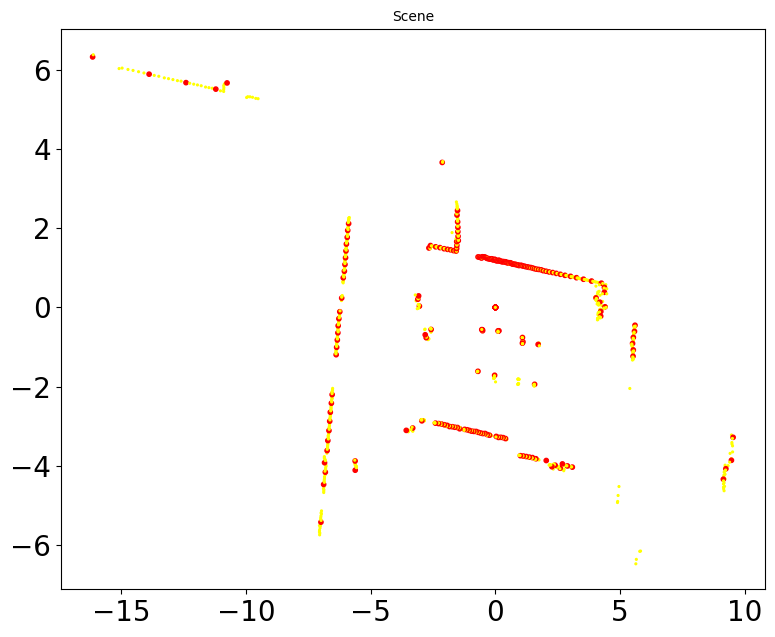

In [84]:
plt.figure(figsize=(20, 16))

data[data>100]=0

x, y = get_image(data)
c = get_color(weights)
s = get_shape(weights)

print(len(x))


ax=plt.subplot(221)
plt.title("Scene" , fontsize=10)
plt.scatter(x, y, s=s, c=c)
# 获取当前子图的坐标轴对象
ax = plt.gca()

# 设置横纵坐标轴标签的字体大小
ax.set_xlabel('', fontsize=5)
ax.set_ylabel('', fontsize=5)

# 设置横纵坐标轴刻度标签的字体大小
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(20)

    
    
# # 调整子图之间的间距
# plt.subplots_adjust(wspace=0.2, hspace=0.2)  # wspace 控制水平间距，hspace 控制垂直间距
# # plt.savefig("Effectiveness Analysis5.")
# # plt.savefig("Effectiveness Analysis5.pdf")
plt.show()

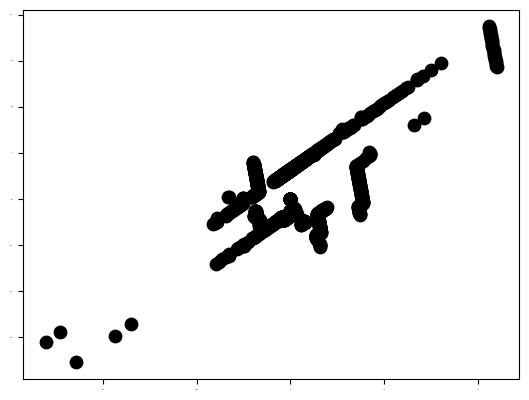

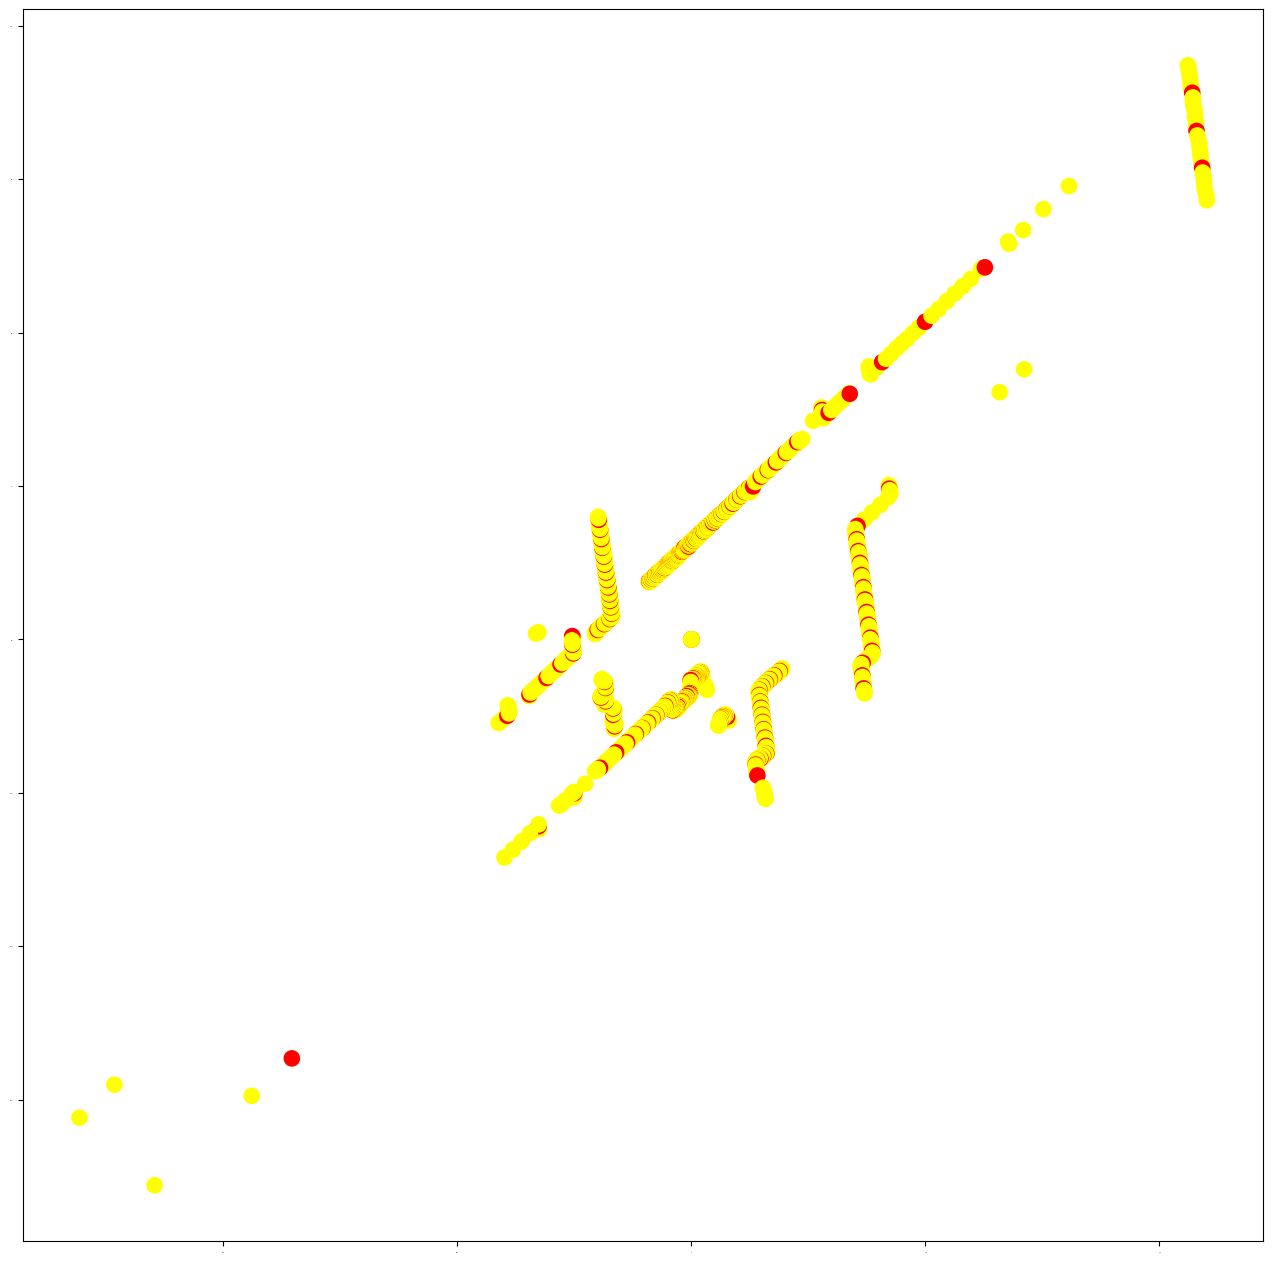

In [78]:
x, y = get_image(data)
plt.scatter(x, y, c="black",s=80)  # 绘制点，颜色为黑色
#     plt.title("Raw Data", fontsize=50)  # 设置标题
#     plt.xlabel('', fontsize=40)
#     plt.ylabel('', fontsize=40)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontsize(0)

plt.show()  # 显示图形

# 第二幅图
plt.figure(figsize=(16, 16))  # 为第二幅图创建新的图形对象
c = get_color(weights)  # 根据注意力权重获取颜色值
plt.scatter(x, y, c=c,s=120)  # 绘制点，颜色根据注意力权重确定
#     plt.title("Weighted Data", fontsize=50)  # 设置标题
#     plt.xlabel('', fontsize=40)
#     plt.ylabel('', fontsize=40)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontsize(0)

plt.show()  # 显示图形